In [2]:
import torchvision
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F # 内置的激活函数

from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn

#### 添加数据

In [ ]:
train_ds = torchvision.datasets.FashionMNIST('data',
                                      train=True,
                                      transform=ToTensor(),
                                      download=True)

test_ds = torchvision.datasets.FashionMNIST('data',
                                      train=False,
                                      transform=ToTensor(),
                                      download=True)



#### 数据预处理

torch.Size([64, 1, 28, 28])

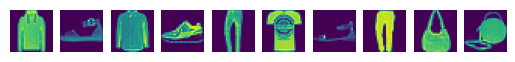

In [13]:
# 批次管理训练
train_dl = DataLoader(train_ds, batch_size=64,shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64) # 测试无需乱序处理

imgs, labels = next(iter(train_dl)) # 获取64个数据

for i, img in enumerate(imgs[:10], start=0): # 前10张图
    img = np.squeeze(img) # 去除维度为1的
    plt.subplot(1, 10, i+1) # 1行10列
    plt.imshow(img) # 画图
    plt.axis('off') # 关闭坐标系
imgs.size()

#### 创建模型

In [5]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(1*28*28, 120)
        self.linear2 = nn.Linear(120, 84)
        self.linear3 = nn.Linear(84, 10)
    def forward(self, input):
        x = input.view(-1, 1*28*28) # tensor标准化
        x = F.relu(self.linear1(x)) # 激活
        x = F.relu(self.linear2(x)) # 激活
        logits = self.linear3(x) # 未激活的叫做logits
        return logits 


model = Model().to('cuda')   # 初始化模型，放到GPU上

# 交叉熵损失函数(合并了Softmax激活函数)
loss_fn = torch.nn.CrossEntropyLoss() # 多分类 参考lr=0.001
opt = torch.optim.Adam(model.parameters(), lr=0.001) # 集大成优化器

#### 创建模板方法(训练/测试)

In [7]:
# 训练函数
def train(train_dl, model, loss_fn, optimizer):
    size = len(train_dl.dataset) # 总的个数    
    num_batches = len(train_dl) # 总批次数 = 总的个数//每批数
        
    train_loss, correct = 0, 0 # 损失率，正确率
        
    for x, y in train_dl:
        x, y = x.to('cuda'), y.to('cuda')
        pred = model(x)
        loss = loss_fn(pred, y)
        
        # 三大步
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            # pred 第一维是每批数 
            correct += (pred.argmax(1) == y).float().sum().item()
            train_loss += loss.item()
    correct /= size
    train_loss /= num_batches # 计算损失是分批训练的
    
    return correct, train_loss

# 测试函数 无需跟踪梯度
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 总的个数       
    num_batches = len(test_dl) # 总批次数 = 总的个数//每批数
    
    test_loss, correct = 0, 0 # 损失率，正确率
    
    # 截断跟踪
    with torch.no_grad():
        for x, y in test_dl:
            x, y = x.to('cuda'), y.to('cuda')
            pred = model(x)         
            loss = loss_fn(pred, y)
            
            correct += (pred.argmax(1) == y).float().sum().item()
            test_loss += loss.item()
        correct /= size
        test_loss /= num_batches # 计算损失是分批训练的
        return correct, test_loss

#### 创建模板方法(获取数据)

In [8]:
def fit(epochs, train_dl, test_dl, model, loss_fn, opt):
    # 用列表记录每轮的数据
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
        epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
        
        # 追加到列表中
        train_acc.append(epoch_train_acc)
        train_loss.append(epoch_train_loss)
        test_acc.append(epoch_test_acc)
        test_loss.append(epoch_test_loss)
        
        # 打印模板
        template = ("epoch:{:2d}, train_Loss:{:.5f}, train_acc:{:.1f},test_Loss:{:.5f}, test_acc:{:.1f}")
        
        print(template.format(epoch, epoch_train_loss, epoch_train_acc*100, epoch_test_loss, epoch_test_acc*100))
    print('Done')
    return train_loss,train_acc,test_loss,test_acc

#### 训练轮数

epoch: 0, train_Loss:0.55579, train_acc:80.2,test_Loss:0.45545, test_acc:83.6
epoch: 1, train_Loss:0.38689, train_acc:86.0,test_Loss:0.40832, test_acc:85.2
epoch: 2, train_Loss:0.34844, train_acc:87.2,test_Loss:0.39067, test_acc:85.8
epoch: 3, train_Loss:0.32267, train_acc:88.1,test_Loss:0.35961, test_acc:86.9
epoch: 4, train_Loss:0.30574, train_acc:88.7,test_Loss:0.35538, test_acc:87.4
epoch: 5, train_Loss:0.29061, train_acc:89.2,test_Loss:0.35018, test_acc:87.3
epoch: 6, train_Loss:0.27905, train_acc:89.7,test_Loss:0.34823, test_acc:87.6
epoch: 7, train_Loss:0.26749, train_acc:90.0,test_Loss:0.35725, test_acc:87.3
epoch: 8, train_Loss:0.25785, train_acc:90.3,test_Loss:0.32998, test_acc:88.4
epoch: 9, train_Loss:0.24929, train_acc:90.7,test_Loss:0.32948, test_acc:88.1
epoch:10, train_Loss:0.23936, train_acc:91.0,test_Loss:0.35007, test_acc:87.8
epoch:11, train_Loss:0.23009, train_acc:91.4,test_Loss:0.33836, test_acc:88.3
epoch:12, train_Loss:0.22425, train_acc:91.5,test_Loss:0.32173, 

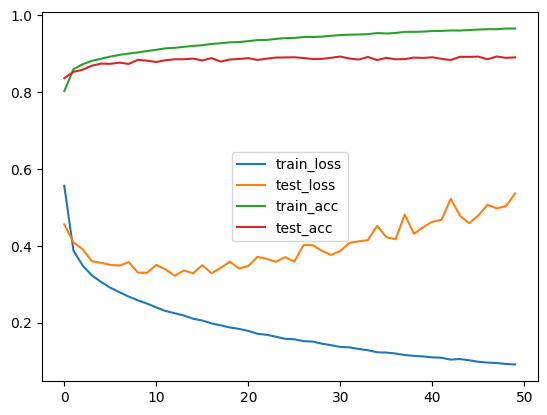

In [9]:
epochs = 50 # 轮数

(train_loss,
 train_acc,
 test_loss,
 test_acc) = fit(epochs=epochs, train_dl=train_dl, test_dl=test_dl, model=model, loss_fn=loss_fn, opt=opt)

# 画图
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), test_loss, label='test_loss')
plt.legend()

plt.plot(range(epochs), train_acc, label='train_acc')
plt.plot(range(epochs), test_acc, label='test_acc')
plt.legend() 